# Cortical Distribution of Temporal Receptive Windows in ECoG during Story Listening

Listening to stories requires the brain to process linguistic information over multiple time-scales to understand the narrative, from phonemes to words, sentences, and paragraphs. Different brain areas may have different processing time-scales—temporal receptive windows (TRWs)—over which they accumulate information; for example, low-level auditory areas operate over short time-scales, while high-level cortical areas integrate information over longer periods. In this study, we quantify temporal receptive fields across the cortical processing hierarchy during naturalistic story listening. We analyzed electrocorticography (ECoG) signals from 160 electrodes across N = 10 subjects listening to a 30-minute spoken narrative (a podcast episode). To quantify TRWs, we estimated the autocorrelation function (ACF) at each electrode, which measures the similarity of a signal with a delayed version of itself over varying time lags. The width of the autocorrelation function (ACW) indicates the TRW length, with wider ACWs suggesting longer TRWs. In line with [previous work](https://pubmed.ncbi.nlm.nih.gov/23083743/), we find that ACWs vary across cortical electrodes during speech comprehension, suggesting that different cortical areas encode features of language evolving over varying time-scales.

In [1]:
import os
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import mne
import pandas as pd
import pandasql as ps
from nilearn import plotting

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_56154/1218012526.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read In Subject from Drive

In [37]:
df_sorted= pd.read_csv('ecog-sorted2024.csv')
df_sorted.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec
0,662,EEGPO_02REF,-62.0,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2
1,717,LGA47,-74.0,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47
2,717,LGB119,-72.0,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119
3,717,LGB126,-74.0,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126
4,717,LGB71,-58.0,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71


In [38]:
df_sorted.shape

(160, 8)

In [40]:
all_ecog_data = []
all_ch_names = []
all_ch_pos = {}

# Iterate through unique subject numbers
for subject in df_sorted['subject_number'].unique():
    # Get electrodes for the current subject
    subject_df = df_sorted[df_sorted['subject_number'] == subject]
    electrodes = subject_df['elec'].tolist()
    
    ecog_data = []

    for elec in electrodes:
        # Get the corresponding electrode row
        electrode_row = subject_df[subject_df['elec'] == elec]
        electrode_name = electrode_row['electrode_name'].values[0]
        
        # Building the filename
        filename = f"/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY{subject}_111_Part1_conversation1/raw/NY{subject}_111_Part1_conversation1_electrode_raw_file_{elec}.mat"
        mat = scipy.io.loadmat(filename)['electrode_data']
        ecog_data.append(mat[0])

        # Create a unique key combining subject and electrode name
        unique_key = f"NY{subject}_{electrode_name}"
        
        # Add the channel position
        all_ch_pos[unique_key] = (electrode_row['x'].values[0], 
                                      electrode_row['y'].values[0], 
                                      electrode_row['z'].values[0])
        all_ch_names.append(unique_key)

    all_ecog_data.extend(ecog_data)

all_ecog_data = np.vstack(all_ecog_data)

# Print the shape of the data for verification
print(all_ecog_data.shape)  # Should be (number_of_electrodes, 921601)


sfreq = 512
info = mne.create_info(ch_names=all_ch_names, sfreq=sfreq, ch_types=['ecog'] * len(all_ch_names))


montage = mne.channels.make_dig_montage(ch_pos=all_ch_pos, coord_frame='mri')

# Double checking all channels are present in montage
missing_channels = set(all_ch_names) - set(montage.ch_names)
if missing_channels:
    raise ValueError(f"Channels missing from montage: {missing_channels}")

info.set_montage(montage)


raw = mne.io.RawArray(all_ecog_data, info)

(160, 921601)
Creating RawArray with float64 data, n_channels=160, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_56154/2287083473.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(montage)


In [686]:
raw.save('raw-ecog-data_ieeg.fif')

Writing /Users/tevaughnshaw/ECOG/raw-ecog-data_ieeg.fif
    Writing channel names to FIF truncated to 15 characters with remapping
Closing /Users/tevaughnshaw/ECOG/raw-ecog-data_ieeg.fif
[done]


In [77]:
# load data
raw = mne.io.read_raw_fif('raw-ecog-data_ieeg.fif')

Opening raw data file raw-ecog-data_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


# zaid test

In [687]:
all_ecog_data.shape

(160, 921601)

In [651]:
df_sorted[df_sorted.region.str.startswith('mSTG')]

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,ACW_third_chunk,ACW_combined
39,717,LGA37,-69.333333,-0.666667,-3.000000,mSTG,NY717_111_Part1_conversation1_LGA37,37,1.267159,1.279528,1.277679,1.274789
40,717,LGA38,-72.000000,-11.333333,2.666667,mSTG,NY717_111_Part1_conversation1_LGA38,38,1.191147,1.212310,1.212776,1.205411
41,717,LGB112,-68.000000,2.666667,-5.333333,mSTG,NY717_111_Part1_conversation1_LGB112,112,1.269471,1.279309,1.277501,1.275427
42,717,LGB113,-72.000000,-6.000000,0.000000,mSTG,NY717_111_Part1_conversation1_LGB113,113,1.284848,1.294503,1.297661,1.292337
43,717,LGB114,-72.857143,-17.142857,5.142857,mSTG,NY717_111_Part1_conversation1_LGB114,114,1.200254,1.223545,1.221141,1.214980
44,717,LGB120,-72.000000,-13.333333,-2.666667,mSTG,NY717_111_Part1_conversation1_LGB120,120,1.294810,1.301820,1.302934,1.299855
45,717,LGB121,-73.000000,-19.000000,0.000000,mSTG,NY717_111_Part1_conversation1_LGB121,121,1.259885,1.269130,1.264344,1.264453
38,717,LGA36,-68.000000,8.000000,-8.000000,mSTG,NY717_111_Part1_conversation1_LGA36,36,1.205870,1.236985,1.236273,1.226376
46,741,GA44,-69.333333,4.000000,-1.333333,mSTG,NY741_111_Part1_conversation1_GA44,43,1.262977,1.233496,1.264584,1.253685
47,741,GA45,-71.000000,-6.000000,6.000000,mSTG,NY741_111_Part1_conversation1_GA45,44,1.287512,1.261585,1.286893,1.278663


In [8]:
elec1_id = 39
elec2_id = 94

In [26]:
test_raw = raw.copy()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB

-0.003129961395327339
1.299243163127863
1.3008375175314413


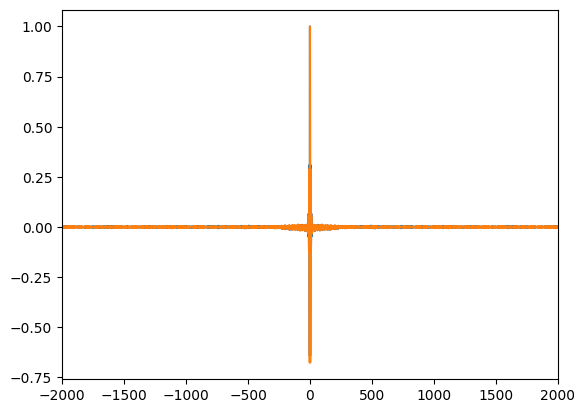

In [27]:
test_raw = test_raw.resample(400)
test_raw = test_raw.notch_filter([60,120,180])
test_raw = test_raw.filter(l_freq=64, h_freq=199, method='iir')

data = test_raw.get_data()

elec1 = data[elec1_id]
elec2 = data[elec2_id]

print(np.corrcoef(elec1, elec2)[0, 1])

corrs, lags = auto_corr(elec1, elec1, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

corrs, lags = auto_corr(elec2, elec2, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

plt.xlim(-400*5, 400*5)
plt.show()

In [29]:
corrs1, lags = auto_corr(elec1, elec1, norm=True)
corrs2, lags = auto_corr(elec2, elec2, norm=True)
print(np.corrcoef(corrs1, corrs2)[0, 1])

0.5705113670588899


# Downsample

In [255]:
new_sfreq = 400
raw_resampled = raw.copy().resample(new_sfreq)

In [45]:
len(raw_resampled) / new_sfreq

1800.0025

In [694]:
len(raw) / 512

1800.001953125

In [6]:
data = raw_resampled.get_data()
data.shape

(160, 720001)

-0.039152286069214386
138.27283556412914
1003.0848540786515


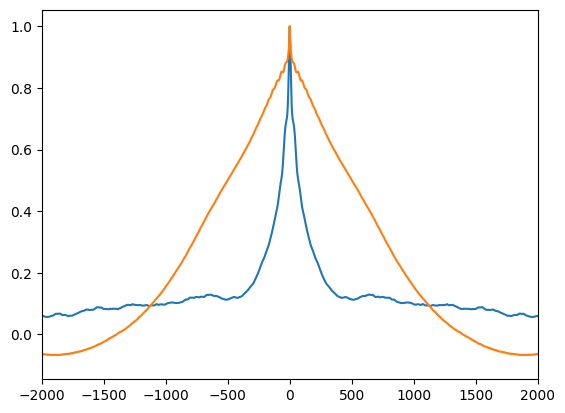

In [12]:
elec1 = data[elec1_id]
elec2 = data[elec2_id]
print(np.corrcoef(elec1, elec2)[0, 1])

corrs, lags = auto_corr(elec1, elec1, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

corrs, lags = auto_corr(elec2, elec2, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

plt.xlim(-new_sfreq*5, new_sfreq*5)
plt.show()

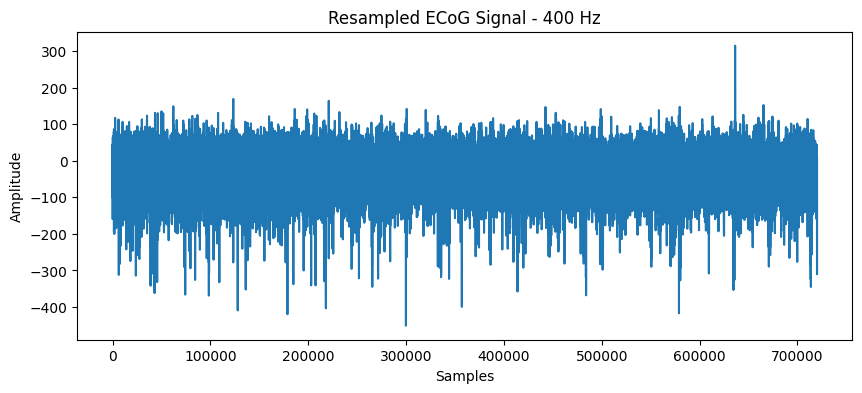

In [192]:
# plot resampled signal
plt.figure(figsize=(10, 4))
plt.plot(data[0])
plt.title('Resampled ECoG Signal - 400 Hz')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Power spectrum 

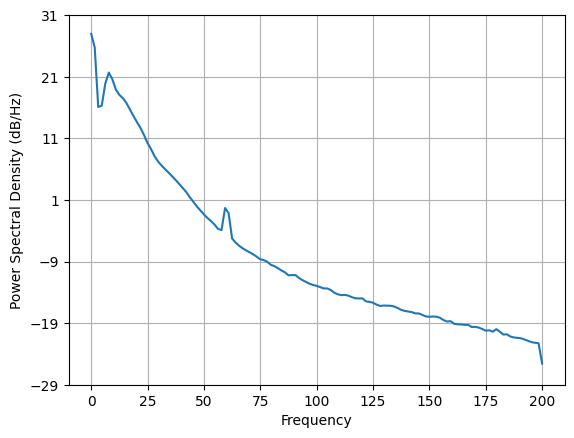

In [193]:
Pxx, freqs = plt.psd(data[0], Fs=raw_resampled.info['sfreq'])
plt.show()

# Notch Filtering

Removing power noise frequency bands 60, 120, & 180.

In [256]:
freqs = [60,120,180]
ecog_no_noise = raw_resampled.notch_filter(freqs)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.0s


-0.03919374530651169
138.54503858437238
1003.7181807166364


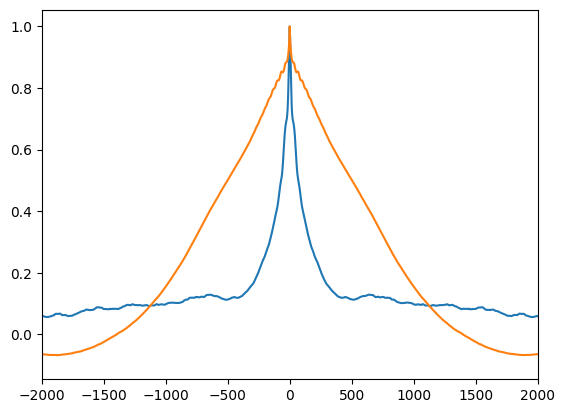

In [14]:
ecog_no_noise_data = ecog_no_noise.get_data()

elec1 = ecog_no_noise_data[elec1_id]
elec2 = ecog_no_noise_data[elec2_id]
print(np.corrcoef(elec1, elec2)[0, 1])

corrs, lags = auto_corr(elec1, elec1, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

corrs, lags = auto_corr(elec2, elec2, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

plt.xlim(-new_sfreq*5, new_sfreq*5)
plt.show()

Effective window size : 5.120 (s)
Plotting power spectral density (dB=True).


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_29135/1791565242.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  ecog_no_noise.compute_psd().plot(axes=ax)


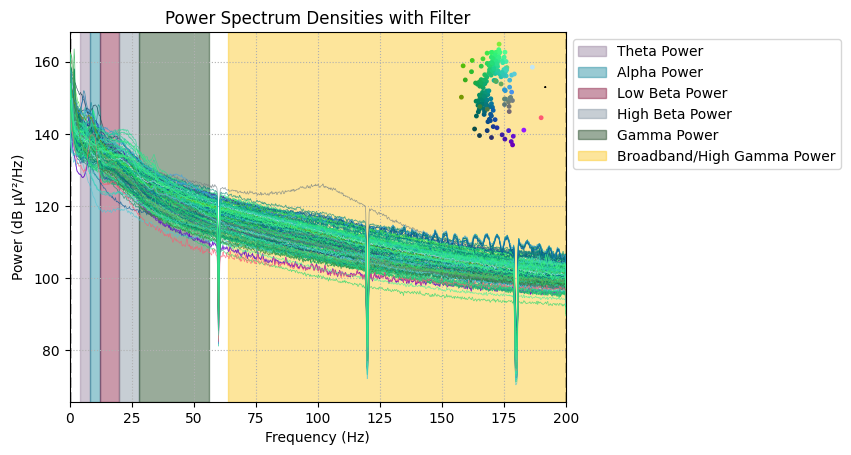

In [562]:
fig, ax = plt.subplots()
ecog_no_noise.compute_psd().plot(axes=ax)
ax.axvspan(4, 8, alpha=0.4, color='#887191', label='Theta Power')
ax.axvspan(8, 12, alpha=0.4, color='#017b92', label='Alpha Power')
ax.axvspan(12, 20, alpha=0.4, color='#7b002c', label='Low Beta Power')
ax.axvspan(20, 28, alpha=0.4, color='#738595', label='High Beta Power')
ax.axvspan(28, 56, alpha=0.4, color='#002d04', label='Gamma Power')
ax.axvspan(64, 200, alpha=0.4, color='#fcc006', label='Broadband/High Gamma Power')
ax.set_title('Power Spectrum Densities with Filter')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('power-spectrums.svg')
plt.show()

## Extracting High Gamma Frequency Bands (64-200 Hz)

In [278]:
raw = mne.io.read_raw_fif('ecog-filtered-broadband-data_ieeg.fif')
raw.load_data()
# ecog_filtered = ecog_no_noise.filter(l_freq=4, 
#                                      h_freq=8, 
raw.notch_filter([60,120,180])
raw.filter(l_freq=64, h_freq=199, method='iir')
raw.apply_hilbert(envelope=True)
raw.resample(400)
raw

Opening raw data file ecog-filtered-broadband-data_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 720000 =      0.000 ...  1800.000 secs
Ready.
Reading 0 ... 720000  =      0.000 ...  1800.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB

Sampling frequency of the instance is already 400.0, returning unmodified.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,160 points
Good channels,160 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,64.00 Hz
Lowpass,199.00 Hz


In [81]:
# save ecog raw 64-200
ecog_filtered.save('ecog-filtered-broadband-data_ieeg.fif')

Writing /Users/tevaughnshaw/ECOG/ecog-filtered-broadband-data_ieeg.fif
    Writing channel names to FIF truncated to 15 characters with remapping
Closing /Users/tevaughnshaw/ECOG/ecog-filtered-broadband-data_ieeg.fif
[done]


In [282]:
ecog_filtered = raw.copy()

ecog_filtered.get_data().shape

(160, 720001)

-0.003129961395327339
1.299243163127863
1.3008375175314413


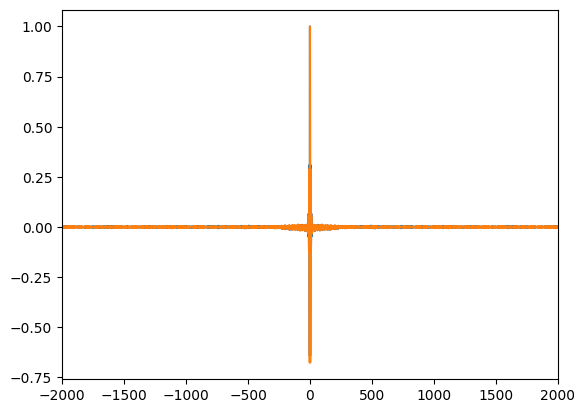

In [17]:
elec1 = ecog_filtered_data[elec1_id]
elec2 = ecog_filtered_data[elec2_id]
print(np.corrcoef(elec1, elec2)[0, 1])

corrs, lags = auto_corr(elec1, elec1, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

corrs, lags = auto_corr(elec2, elec2, norm=True)
plt.plot(lags, corrs)
a, b = spline_graph(lags, corrs)
print(b - a)

plt.xlim(-new_sfreq*5, new_sfreq*5)
plt.show()

In [283]:
# create copies since .crop is inplace

ecog_filter1 = ecog_filtered.copy()
ecog_filter2 = ecog_filtered.copy()
ecog_filter2.get_data().shape

(160, 720001)

In [234]:
ecog_filtered.crop?

Signature: ecog_filtered.crop(tmin=0.0, tmax=None, include_tmax=True, *, verbose=None)
Docstring:
Crop raw data file.

Limit the data from the raw file to go between specific times. Note
that the new ``tmin`` is assumed to be ``t=0`` for all subsequently
called functions (e.g., :meth:`~mne.io.Raw.time_as_index`, or
:class:`~mne.Epochs`). New :term:`first_samp` and :term:`last_samp`
are set accordingly.

Thus function operates in-place on the instance.
Use :meth:`mne.io.Raw.copy` if operation on a copy is desired.

Parameters
----------

tmin : float
    Start time of the raw data to use in seconds (must be >= 0).

tmax : float
    End time of the raw data to use in seconds (cannot exceed data duration).

include_tmax : bool
    If True (default), include tmax. If False, exclude tmax (similar to how
    Python indexing typically works).

    .. versionadded:: 0.19

verbose : bool | str | int | None
    Control verbosity of the logging output. If ``None``, use the default
    verbosity l

## Create 10 Minute Segments from Signal

In [284]:
first_raw = ecog_filtered.crop(tmin=0, tmax=599) # first 10 mins
second_raw = ecog_filter1.crop(tmin=600, tmax=1199) # second 10 mins
third_raw = ecog_filter2.crop(tmin=1200, tmax=1799) # last 10 mins
first_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,160 points
Good channels,160 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,64.00 Hz
Lowpass,199.00 Hz


In [285]:
# Array split to 20 secs
first_data = np.array_split(first_raw.get_data(), 30, axis=1)
print('Number of arrays [first 10 min segment]:', len(first_data))
# [e.shape for e in first_data]
second_data = np.array_split(second_raw.get_data(), 30, axis=1)
print('Number of arrays [second 10 min segment]:', len(second_data))
# [r.shape for r in second_data]
third_data = np.array_split(third_raw.get_data(), 30, axis=1)
print('Number of arrays [last 10 min segment]:', len(third_data))
# [t.shape for t in third_data]

Number of arrays [first 10 min segment]: 30
Number of arrays [second 10 min segment]: 30
Number of arrays [last 10 min segment]: 30


In [204]:
[e.shape for e in first_data]

[(160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7987),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986),
 (160, 7986)]

## Autocorrelation Function

In [50]:
from scipy.signal import correlate, correlation_lags

def auto_corr(
    x: np.ndarray,
    y: np.ndarray,
    mode="same",
    method="fft",
    norm=True,
    maxlags=None
):
    """General function to compute auto correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

## Autocorrelation Width Function

In [51]:
# Gaussian dist of values for better FWHM plotting of points
from scipy.interpolate import UnivariateSpline

# create spline function
def spline_graph(t, r):
    spline = UnivariateSpline(t, r-np.max(r)/2, s=0)
    roots = spline.roots()
    if len(roots) > 2:
        half_root_indx = len(roots) // 2
        r2 = roots[half_root_indx]
        r1 = roots[half_root_indx - 1]
    elif len(roots)==2:
        r1, r2 = spline.roots() # find the roots
    return r1, r2

Original freq: 512 Hz (samples / sec)<br>
1 s = 512 samples<br>
1.953125 ms = 1 sample<br>

Sample freq: 400 Hz<br>
1 s = 400 samples<br>
2.5 ms = 1 sample

## Fixing Spline Graph Function

Ran into a situation where doing UnivariateSpline returned more than two roots, which was too much to unpack for r1,r2. The code below shows a case where 6 roots were returned so to handle this, took the length of the roots array and divided by half. Whichever value is in the last index is the r2 and r1 is half index - 1. From there the function can continue to return r2 and r1 for further processing. [Source](https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak) for spline function.

[-4.30305105 -3.9767945  -0.6570042   0.6570042   3.9767945   4.30305105]


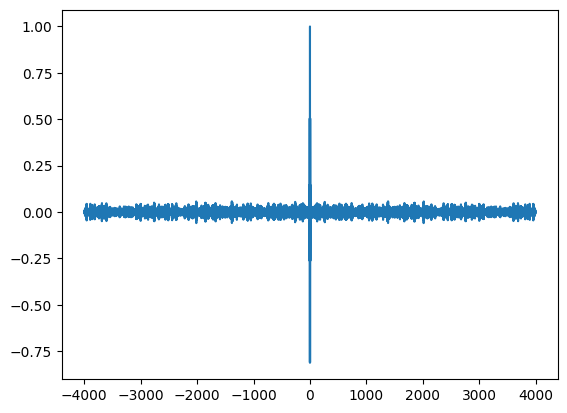

In [218]:
tmp = first_data[0][40]
corr, lags = auto_corr(tmp, tmp)
print(UnivariateSpline(lags, corr-np.max(corr)/2, s=0).roots())
plt.plot(lags, corr);
plt.show()


## Calculating ACW for Each of Three Chunks and Their Mean

In [52]:
from collections import defaultdict

In [286]:
# ZZ suggestion:

ACW_first = np.zeros((len(data), len(first_data)))

first_corr_results = defaultdict(list)
first_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(first_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        # print(i, j, chunk.shape, electrode_chunk.shape)
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        # print(i, j, corr.shape, lags.shape)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_first[j, i] = fwhm
        
        first_corr_results[j].append(corr[3500:4500])
        first_lag_results[j].append(lags[3500:4500])

first_results = first_corr_results # correlations
first_time = first_lag_results # time lags

first_ACW_avgs = ACW_first.mean(-1)
first_ACW_avgs

array([ 6.28887521,  5.67278182,  5.87196826,  5.77578938,  5.77218364,
        5.80446633,  5.79368626,  5.8458526 ,  5.95847529,  5.93740952,
        5.85332435,  5.88351618,  6.59717795,  5.75312584,  5.82591426,
        5.85411189,  5.78844105,  6.02114727,  5.86253881,  5.76901545,
        5.80302377,  5.89341156,  5.89663438,  5.73190383,  5.7552371 ,
        6.17791162,  5.75142715,  5.79410981,  5.93272559,  5.71844223,
        5.80770435,  5.65143151,  5.74962472,  5.73079316,  5.72101133,
        5.64620443,  5.84224342,  5.85643272,  5.8079923 ,  9.12926844,
        7.64289618,  7.29959292,  5.82389594,  6.53278434,  9.51965769,
        5.7269766 ,  5.77513889,  5.88936252,  6.03087001,  5.938552  ,
        5.73475062,  5.69113073,  9.56708499,  7.90015774,  7.24701357,
        7.68772678,  6.67820129,  6.85361796,  7.77082836,  7.68988588,
        6.96811772,  5.86659844,  5.91341711,  5.81596597,  6.1997624 ,
        5.90044478,  6.0530991 ,  5.94160694,  5.79350543,  5.74

In [287]:
# ACW for second 10 min segment
ACW_second= np.zeros((len(data), len(second_data)))

second_corr_results = defaultdict(list)
second_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(second_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_second[j, i] = fwhm
        
        second_corr_results[j].append(corr[3500:4500])
        second_lag_results[j].append(lags[3500:4500])
        
second_results = second_corr_results # correlations
second_time = second_lag_results # time lags

second_ACW_avgs = ACW_second.mean(-1)
second_ACW_avgs

array([12.00467064,  5.59710123,  5.92113709,  5.67599777,  5.71158804,
        5.71747159,  5.75194211,  5.66635413,  5.88216341,  5.81900926,
        5.71316126,  5.78015904,  6.46942496,  5.58954066,  5.59694998,
        5.94033514,  5.61223834,  5.90322955,  5.52424359,  5.87027364,
        5.77437432,  5.70623601,  5.8222607 ,  5.62799081,  5.70101157,
        6.20487133,  5.54630828,  5.84427279,  5.86630897,  5.57132371,
        5.70305364,  5.47886295,  5.66027499,  5.61422607,  5.64133207,
        5.56146124,  5.84851687,  5.72162579,  5.65716427,  6.00812645,
        6.59382441,  6.13915579,  5.94779365,  6.50144475,  6.2372759 ,
        5.74109509,  5.81013857,  5.75447543,  5.75104935,  6.08217081,
        5.73588968,  5.72726265,  6.79630275,  7.64302474,  7.39318379,
        7.49524868,  7.20210163,  7.10517355,  7.65705771,  7.54552824,
        7.32401024,  5.993863  ,  5.95005626,  5.78575868,  6.24103948,
        5.84315121,  5.756623  ,  6.18336605,  5.93766569,  5.83

In [288]:
# ACW for third 10 min segment
ACW_third = np.zeros((len(data), len(third_data)))

third_corr_results = defaultdict(list)
third_lag_results = defaultdict(list)

# split_data = [ (n_elec x samples) ]

# for each chunk in the 10-min
for i, chunk in enumerate(third_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACW_third[j, i] = fwhm
        
        third_corr_results[j].append(corr[3500:4500])
        third_lag_results[j].append(lags[3500:4500])

third_results = third_corr_results # correlations
third_time = third_lag_results # time lags


third_ACW_avgs = ACW_third.mean(-1)
third_ACW_avgs

array([ 7.56212492,  5.66723151,  5.87810328,  5.71676707,  5.73383889,
        5.75290899,  5.7846091 ,  5.79841754,  5.88654916,  5.74258959,
        5.92097996,  5.85715376,  6.65884885,  5.69242911,  5.68065786,
        5.92570425,  5.71709771,  5.92829033,  5.7378702 ,  5.83150149,
        5.73268145,  5.83970081,  5.9043367 ,  5.67092639,  5.81966951,
        6.20469023,  5.62053085,  5.80835805,  5.88399388,  5.70245911,
        5.77017583,  5.53193295,  5.72196877,  5.70384593,  5.69434973,
        5.55992397,  5.81247472,  5.85536352,  5.75767884,  5.90464402,
        6.50870323,  6.04337831,  5.93643596,  6.49403726,  6.0400357 ,
        5.75318633,  5.81559986,  5.74233035,  5.76497961,  5.96131068,
        5.71546243,  5.75684612,  6.90857517,  7.43867359,  7.09845135,
        7.16701632,  6.67411211,  6.79591166,  7.3416097 ,  7.22388126,
        7.02377445,  6.01062686,  5.8931398 ,  5.96907876,  6.2346147 ,
        6.00600899,  5.85450062,  6.20176271,  6.07937356,  5.85

## Create DataFrame for Each 10 Minute Chunk to Compute Average ACF Between Regions

In [289]:
# average 30 20-sec chunks per electrode
average_acf_line = []
for a in first_corr_results:
    electrode_autocorr_lines = first_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

first_average_acf_line_df = pd.DataFrame(average_acf_line)
print(first_average_acf_line_df.shape)
first_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.011169,0.009323,0.008772,0.009549,0.011122,0.012694,0.013685,0.014194,0.014700,0.015149,...,0.016282,0.015645,0.014403,0.012768,0.010913,0.009294,0.008304,0.007957,0.008138,0.008647
1,0.004389,0.003665,0.003366,0.003201,0.003387,0.004400,0.006394,0.008615,0.010096,0.010766,...,0.010663,0.010505,0.009810,0.009450,0.009527,0.009831,0.010449,0.011300,0.012044,0.012479
2,0.010609,0.010774,0.010939,0.011107,0.010805,0.009449,0.007133,0.004934,0.003790,0.003882,...,0.008996,0.009002,0.008831,0.008503,0.008235,0.008365,0.008930,0.009406,0.009477,0.009563
3,0.011996,0.010859,0.008897,0.006340,0.003591,0.001337,0.000294,0.000833,0.002610,0.004771,...,0.009855,0.009452,0.009590,0.010196,0.010963,0.011745,0.012819,0.014343,0.015849,0.016645
4,0.008744,0.007871,0.007330,0.007494,0.008034,0.008807,0.009891,0.011019,0.011833,0.012334,...,0.010834,0.011148,0.011107,0.010629,0.009765,0.008479,0.006916,0.005818,0.005556,0.005721


In [290]:
# second 10 min chunk
average_acf_line = []
for a in second_corr_results:
    electrode_autocorr_lines = second_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

second_average_acf_line_df = pd.DataFrame(average_acf_line)
print(second_average_acf_line_df.shape)
second_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.022503,0.024250,0.025761,0.027437,0.029194,0.030359,0.030623,0.030270,0.029624,0.028841,...,0.021674,0.022972,0.023634,0.023621,0.023311,0.023054,0.022592,0.021754,0.021005,0.020764
1,-0.005734,-0.005652,-0.004571,-0.003049,-0.001579,-0.000572,-0.000036,-0.000023,-0.000537,-0.001137,...,0.004534,0.005587,0.005641,0.005074,0.004348,0.003502,0.002359,0.001119,0.000281,0.000283
2,-0.005514,-0.005505,-0.005087,-0.004101,-0.002380,-0.000293,0.001239,0.001849,0.002043,0.002194,...,-0.005127,-0.004635,-0.003767,-0.002710,-0.001954,-0.001890,-0.002274,-0.002829,-0.003625,-0.004492
3,0.004980,0.004816,0.004391,0.003907,0.003220,0.002060,0.000818,0.000028,-0.000492,-0.001024,...,0.002481,0.001535,0.001080,0.000581,-0.000307,-0.001201,-0.002042,-0.003430,-0.005237,-0.006606
4,0.011703,0.010061,0.008288,0.006610,0.005418,0.004498,0.003403,0.002339,0.001917,0.002154,...,0.015247,0.014358,0.012709,0.010782,0.008835,0.006522,0.003845,0.001511,-0.000056,-0.000982


In [291]:
# third 10 min chunk
average_acf_line = []
for a in third_corr_results:
    electrode_autocorr_lines = third_corr_results[a]  # electrode 0 : 159
    electrode_average_acf = np.stack(electrode_autocorr_lines).mean(0)
    average_acf_line.append(electrode_average_acf)
# electrode_average_acf.shape

third_average_acf_line_df = pd.DataFrame(average_acf_line)
print(third_average_acf_line_df.shape)
third_average_acf_line_df.head()

(160, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.028212,0.029042,0.029626,0.029820,0.029729,0.029321,0.028385,0.027403,0.027015,0.026879,...,0.024695,0.023813,0.022945,0.021969,0.020565,0.018968,0.017955,0.017947,0.018472,0.018813
1,0.003078,0.003156,0.003639,0.003698,0.003448,0.003102,0.002214,0.000656,-0.000690,-0.000908,...,0.008097,0.008318,0.007848,0.006652,0.004945,0.003760,0.003633,0.003751,0.003357,0.002738
2,0.002317,0.004073,0.004931,0.004607,0.003517,0.002376,0.001873,0.002361,0.003660,0.005219,...,-0.002463,-0.002175,-0.001504,-0.000886,-0.000709,-0.000733,-0.000169,0.000832,0.001206,0.000630
3,0.000599,0.001984,0.003527,0.005281,0.006819,0.007627,0.007732,0.007527,0.007179,0.006315,...,-0.001567,-0.001887,-0.002324,-0.002697,-0.002917,-0.002922,-0.002628,-0.001782,-0.000551,0.000309
4,0.005181,0.004706,0.003760,0.002660,0.001689,0.001168,0.001279,0.001613,0.001741,0.001694,...,0.002437,0.001495,0.000620,0.000185,0.000658,0.001771,0.002883,0.003635,0.003843,0.003482


In [292]:
first_acf_line_df = pd.concat([df_sorted,first_average_acf_line_df],axis=1)
second_acf_line_df = pd.concat([df_sorted,second_average_acf_line_df],axis=1)
third_acf_line_df = pd.concat([df_sorted,third_average_acf_line_df],axis=1)
print(first_acf_line_df.shape)
print(second_acf_line_df.shape)
print(third_acf_line_df.shape)

(160, 1008)
(160, 1008)
(160, 1008)


In [387]:
# group each df by 'region'
first_region_grouped_df = first_acf_line_df.groupby('region')
second_region_grouped_df = second_acf_line_df.groupby('region')
third_region_grouped_df = third_acf_line_df.groupby('region')

# creating a dictionary to hold the average ACF lines for each region
first_average_acf_lines = {}
second_average_acf_lines = {}
third_average_acf_lines = {}

# Loop through each group, stack and average the specified columns
for region, group in first_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 8:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    first_average_acf_lines[region] = electrode_average_acf


In [587]:
first_region_grouped_df.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,...,990,991,992,993,994,995,996,997,998,999
29,662,EEGPO_02REF,-62.000000,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2,1.268338,1.374682,...,0.000836,-0.003858,-0.001007,0.001218,-0.001020,0.002687,0.002883,-0.001573,-0.005538,-0.001789
31,717,LGA47,-74.000000,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47,1.218432,1.244757,...,0.002994,-0.004604,-0.003044,0.007392,0.002685,-0.003984,-0.004913,-0.000455,0.007208,0.003136
32,717,LGB119,-72.000000,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119,1.285764,1.296811,...,-0.003825,-0.003434,0.002493,0.004678,-0.000154,-0.002212,-0.000493,-0.001960,-0.000484,0.004444
33,717,LGB126,-74.000000,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126,1.265563,1.283214,...,-0.001109,-0.001033,0.000787,0.001456,0.000370,-0.000352,0.000500,-0.000116,-0.003348,-0.001907
136,717,LGB71,-58.000000,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71,1.298568,1.291006,...,-0.004932,-0.001766,0.000789,0.002963,0.002388,0.000096,-0.004128,-0.001566,0.000820,0.001671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,798,O6,-58.000000,-64.000000,25.000000,cMTG,NY798_111_Part1_conversation1_O6,142,1.391903,1.392317,...,0.001960,-0.005475,-0.003858,0.005578,0.005377,-0.002084,-0.004723,-0.002538,0.001169,0.004884
15,798,AIT3,-42.000000,-5.000000,-47.000000,fusiform,NY798_111_Part1_conversation1_AIT3,131,1.348419,1.358038,...,-0.008113,-0.006339,0.003223,0.009220,0.004217,-0.004991,-0.007506,-0.002566,0.004061,0.008666
20,798,O4,-45.333333,-80.000000,33.333333,inferiorparietal,NY798_111_Part1_conversation1_O4,140,1.365886,1.361662,...,-0.004038,-0.004844,0.003547,0.009198,-0.001042,-0.009215,-0.002680,0.004326,0.004970,0.001577
27,798,DPI3,-50.000000,-15.000000,8.000000,Left-Cerebral-White-Matter,NY798_111_Part1_conversation1_DPI3,191,1.315296,1.309490,...,0.001682,0.001899,-0.003639,-0.002572,0.002463,0.003077,0.001333,-0.001512,-0.005070,-0.001461


In [388]:
# second df
for region, group in second_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 8:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    second_average_acf_lines[region] = electrode_average_acf


In [389]:
#third df
for region, group in third_region_grouped_df:
    # Select columns 12 through the end
    selected_columns = group.iloc[:, 8:]
    
    # Stack and average the values
    electrode_average_acf = np.stack(selected_columns.values).mean(axis=0)
    
    # Store the average line for the region
    third_average_acf_lines[region] = electrode_average_acf


In [596]:
third_average_acf_lines['mSTG']

array([ 1.39314409e-03, -2.40022681e-03, -9.37046891e-04,  2.08724049e-03,
       -3.09992805e-04, -1.90874753e-03,  1.41950558e-03,  7.32362584e-04,
       -5.05317202e-04,  4.18404796e-04, -5.92352388e-04, -1.56706980e-03,
        6.52111786e-04,  2.40636620e-03, -3.69344689e-04, -2.23004708e-03,
        7.17990473e-04,  1.18252767e-03, -1.54374104e-03, -1.03008156e-04,
        1.64423259e-03, -4.74174700e-04, -9.95826176e-05, -3.35994433e-04,
       -1.56010540e-04, -5.81725982e-04,  8.16588113e-04,  8.59898676e-04,
       -1.02083340e-03,  2.45110551e-04,  8.53195725e-04, -2.06548976e-03,
       -2.49498119e-04,  2.39354122e-03,  3.53466527e-04, -1.65294524e-03,
       -8.20446395e-04,  1.13316779e-03,  4.21457894e-04, -3.73416956e-04,
        2.38351937e-04, -1.15036324e-03,  5.61421389e-04,  1.55263413e-03,
       -1.00109447e-03, -1.80286012e-03,  1.52773972e-03,  7.58105695e-04,
       -6.40160704e-04, -1.23583063e-04,  2.74205119e-04, -8.83688998e-04,
       -7.60220259e-04,  

In [411]:
xaxis = np.arange(-497, 503)
xaxis.shape

(1000,)

In [442]:
# Function to plot average ACF lines for specified ROIs
def plot_acf_for_rois(acf_dicts, rois, title):
    plt.figure(figsize=(3, 2), dpi=300)
    
    for roi in rois:
        electrode_autocorr_lines = []
        
        # Collect all autocorrelation lines for the ROI from each dictionary
        for acf_dict in acf_dicts:
            if roi in acf_dict:
                electrode_autocorr_lines.append(acf_dict[roi])
            else:
                print(f"ROI {roi} not found in one of the dictionaries")
        
        if electrode_autocorr_lines:
            # Stack and average the values
            electrode_average_acf = np.stack(electrode_autocorr_lines).mean(axis=0)
            # Plot the average ACF line
            plt.plot(xaxis, electrode_average_acf, label=roi)
        else:
            print(f"No data found for ROI {roi} in any dictionary")

    plt.xlabel('Time Lag')
    plt.ylabel('Average ACF')
    # plt.title(title)
    # plt.xlim(500-50,500+50)
    plt.xlim(-100, 100)
    plt.ylim(0, 0.5)
    # plt.legend()
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.grid(True)
    plt.savefig(f"broadband-{title}.png",bbox_inches = 'tight')
    plt.show()

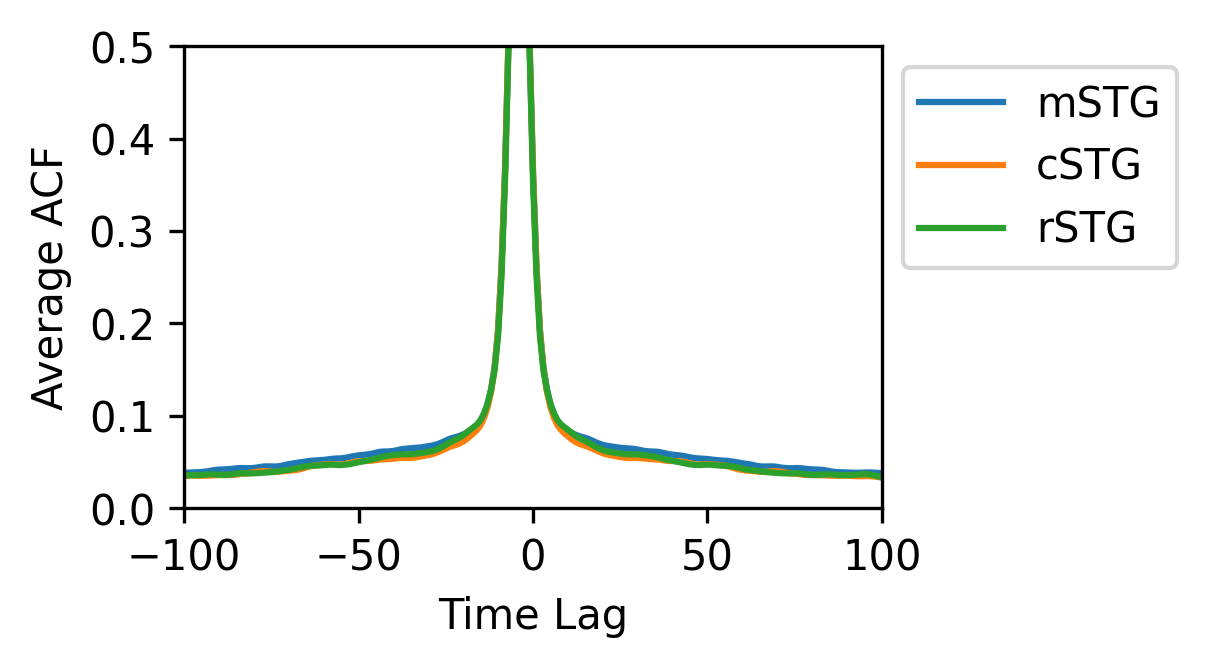

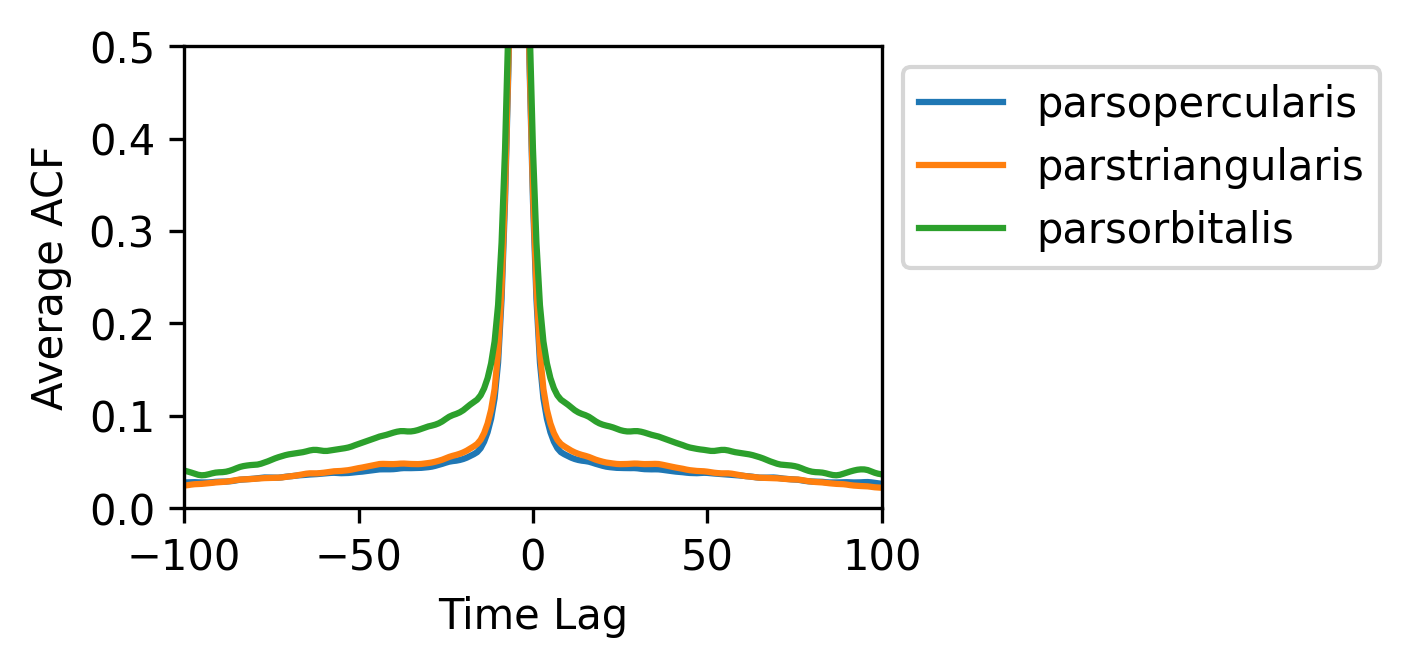

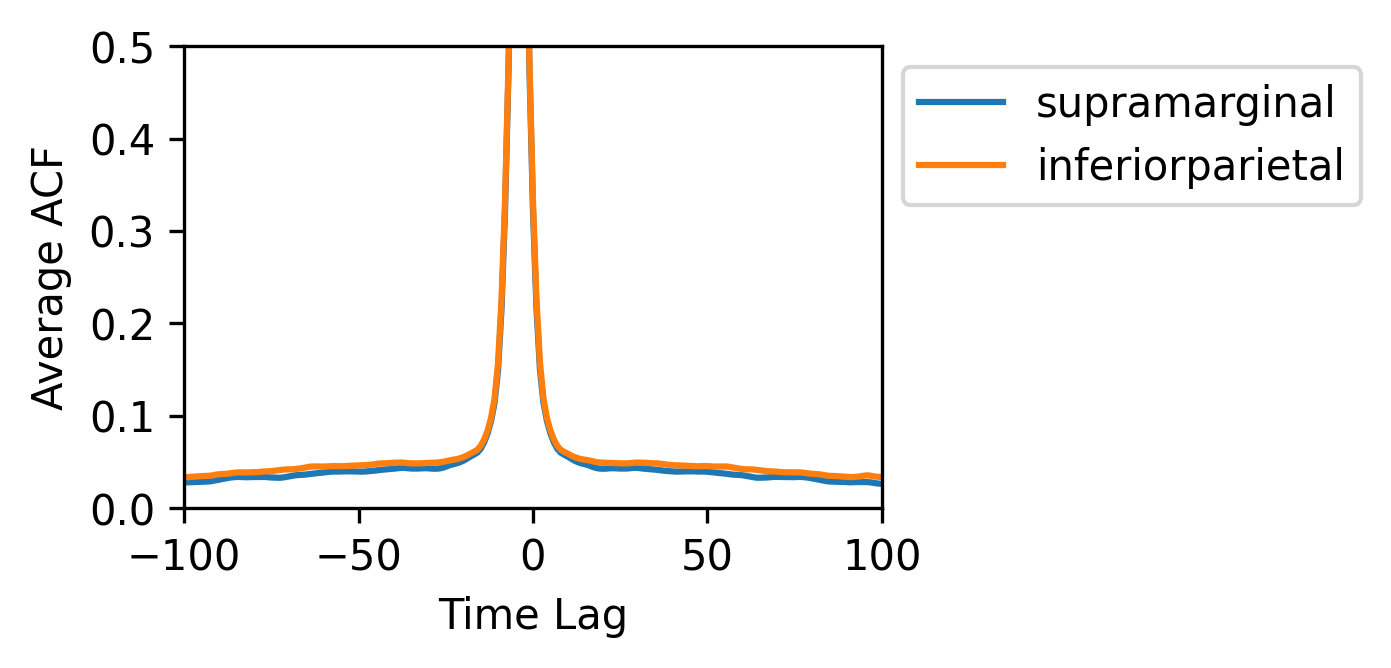

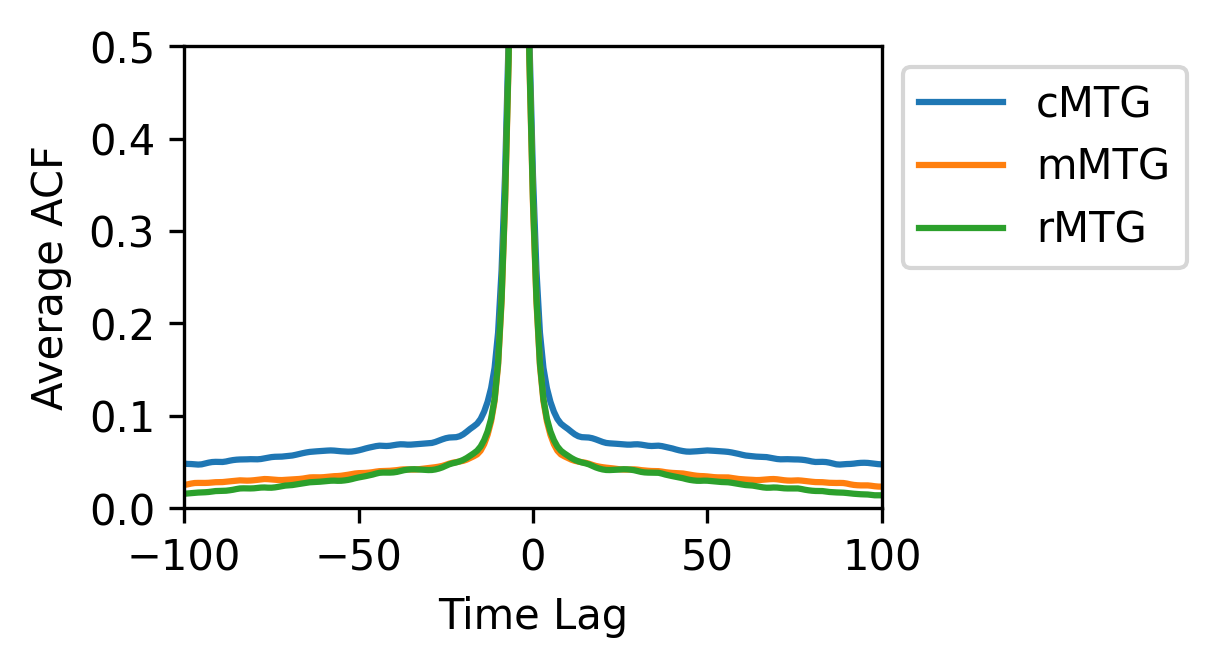

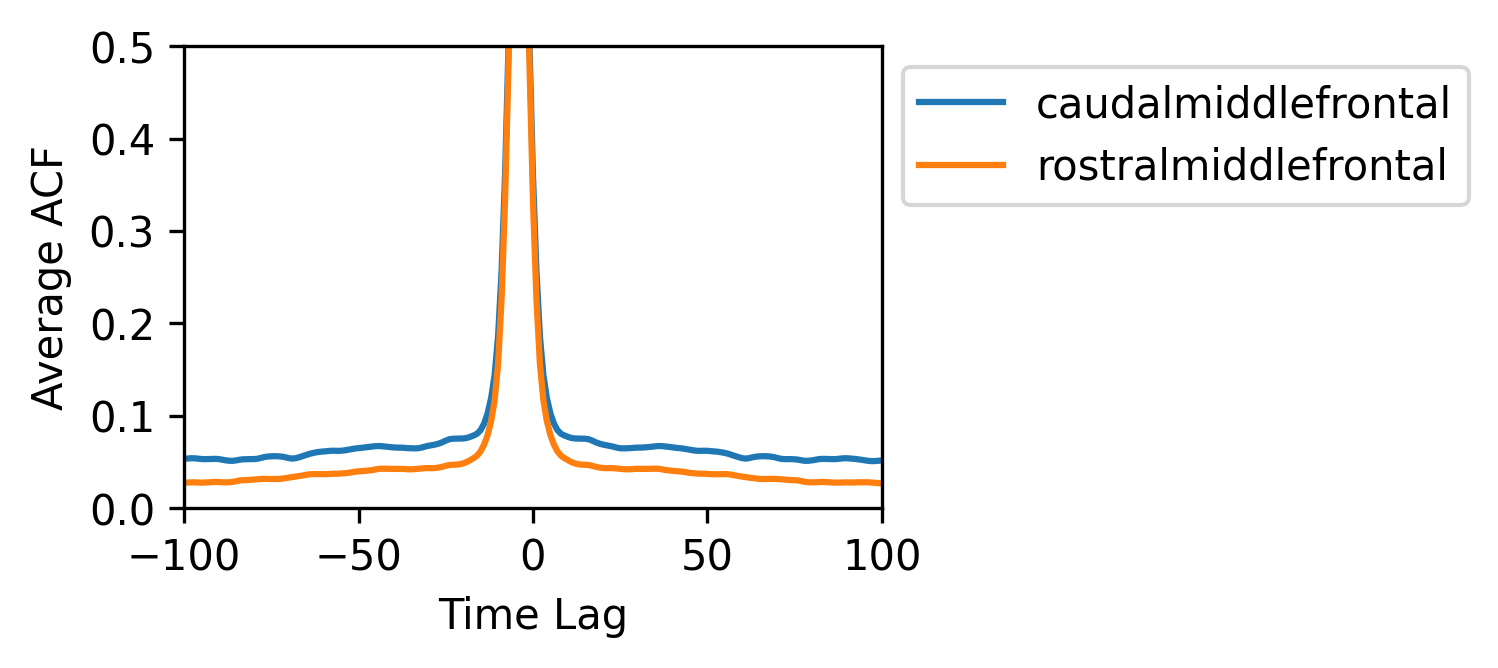

In [443]:
# Define the regions of interest (ROIs) for each plot
rois_list = [
    (['mSTG', 'cSTG', 'rSTG'], 'Average ACF for mSTG, cSTG, rSTG'),
    (['parsopercularis', 'parstriangularis', 'parsorbitalis'], 'Average ACF for parsopercularis, parstriangularis, parsorbitalis'),
    (['supramarginal', 'inferiorparietal'], 'Average ACF for supramarginal, inferiorparietal'),
    (['cMTG', 'mMTG', 'rMTG'], 'Average ACF for cMTG, mMTG, rMTG'),
    (['caudalmiddlefrontal', 'rostralmiddlefrontal'], 'Average ACF for caudalmiddlefrontal, rostralmiddlefrontal')
]
acf_dicts = [first_average_acf_lines,second_average_acf_lines,third_average_acf_lines]
# Plot the average ACF lines for each set of ROIs in each of three dictionary chunks
for rois, title in rois_list:
    plot_acf_for_rois(acf_dicts, rois, title)
    # break

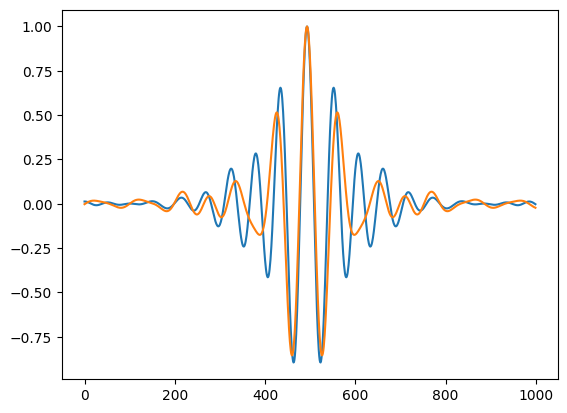

In [486]:
plt.plot(np.stack(first_corr_results[0]).mean(0))
plt.plot(np.stack(first_corr_results[20]).mean(0))

## Create 3 New Columns to Dataframe of the ACW Averages Per Chunk

In [323]:
# Add new columns to df_sorted
df_sorted['ACW_first_chunk'] = first_ACW_avgs
df_sorted['ACW_second_chunk'] = second_ACW_avgs
df_sorted['ACW_third_chunk'] = third_ACW_avgs
df_sorted.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,ACW_third_chunk
0,662,EEGPO_02REF,-62.0,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2,6.288875,12.004671,7.562125
1,717,LGA47,-74.0,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47,5.672782,5.597101,5.667232
2,717,LGB119,-72.0,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119,5.871968,5.921137,5.878103
3,717,LGB126,-74.0,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126,5.775789,5.675998,5.716767
4,717,LGB71,-58.0,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71,5.772184,5.711588,5.733839


## Plot Node Locations and Average ACW Values Using NiLearn

In [68]:
node_coordinates = df_sorted[['x','y','z']].values # node coords in space for plotting in nilearn

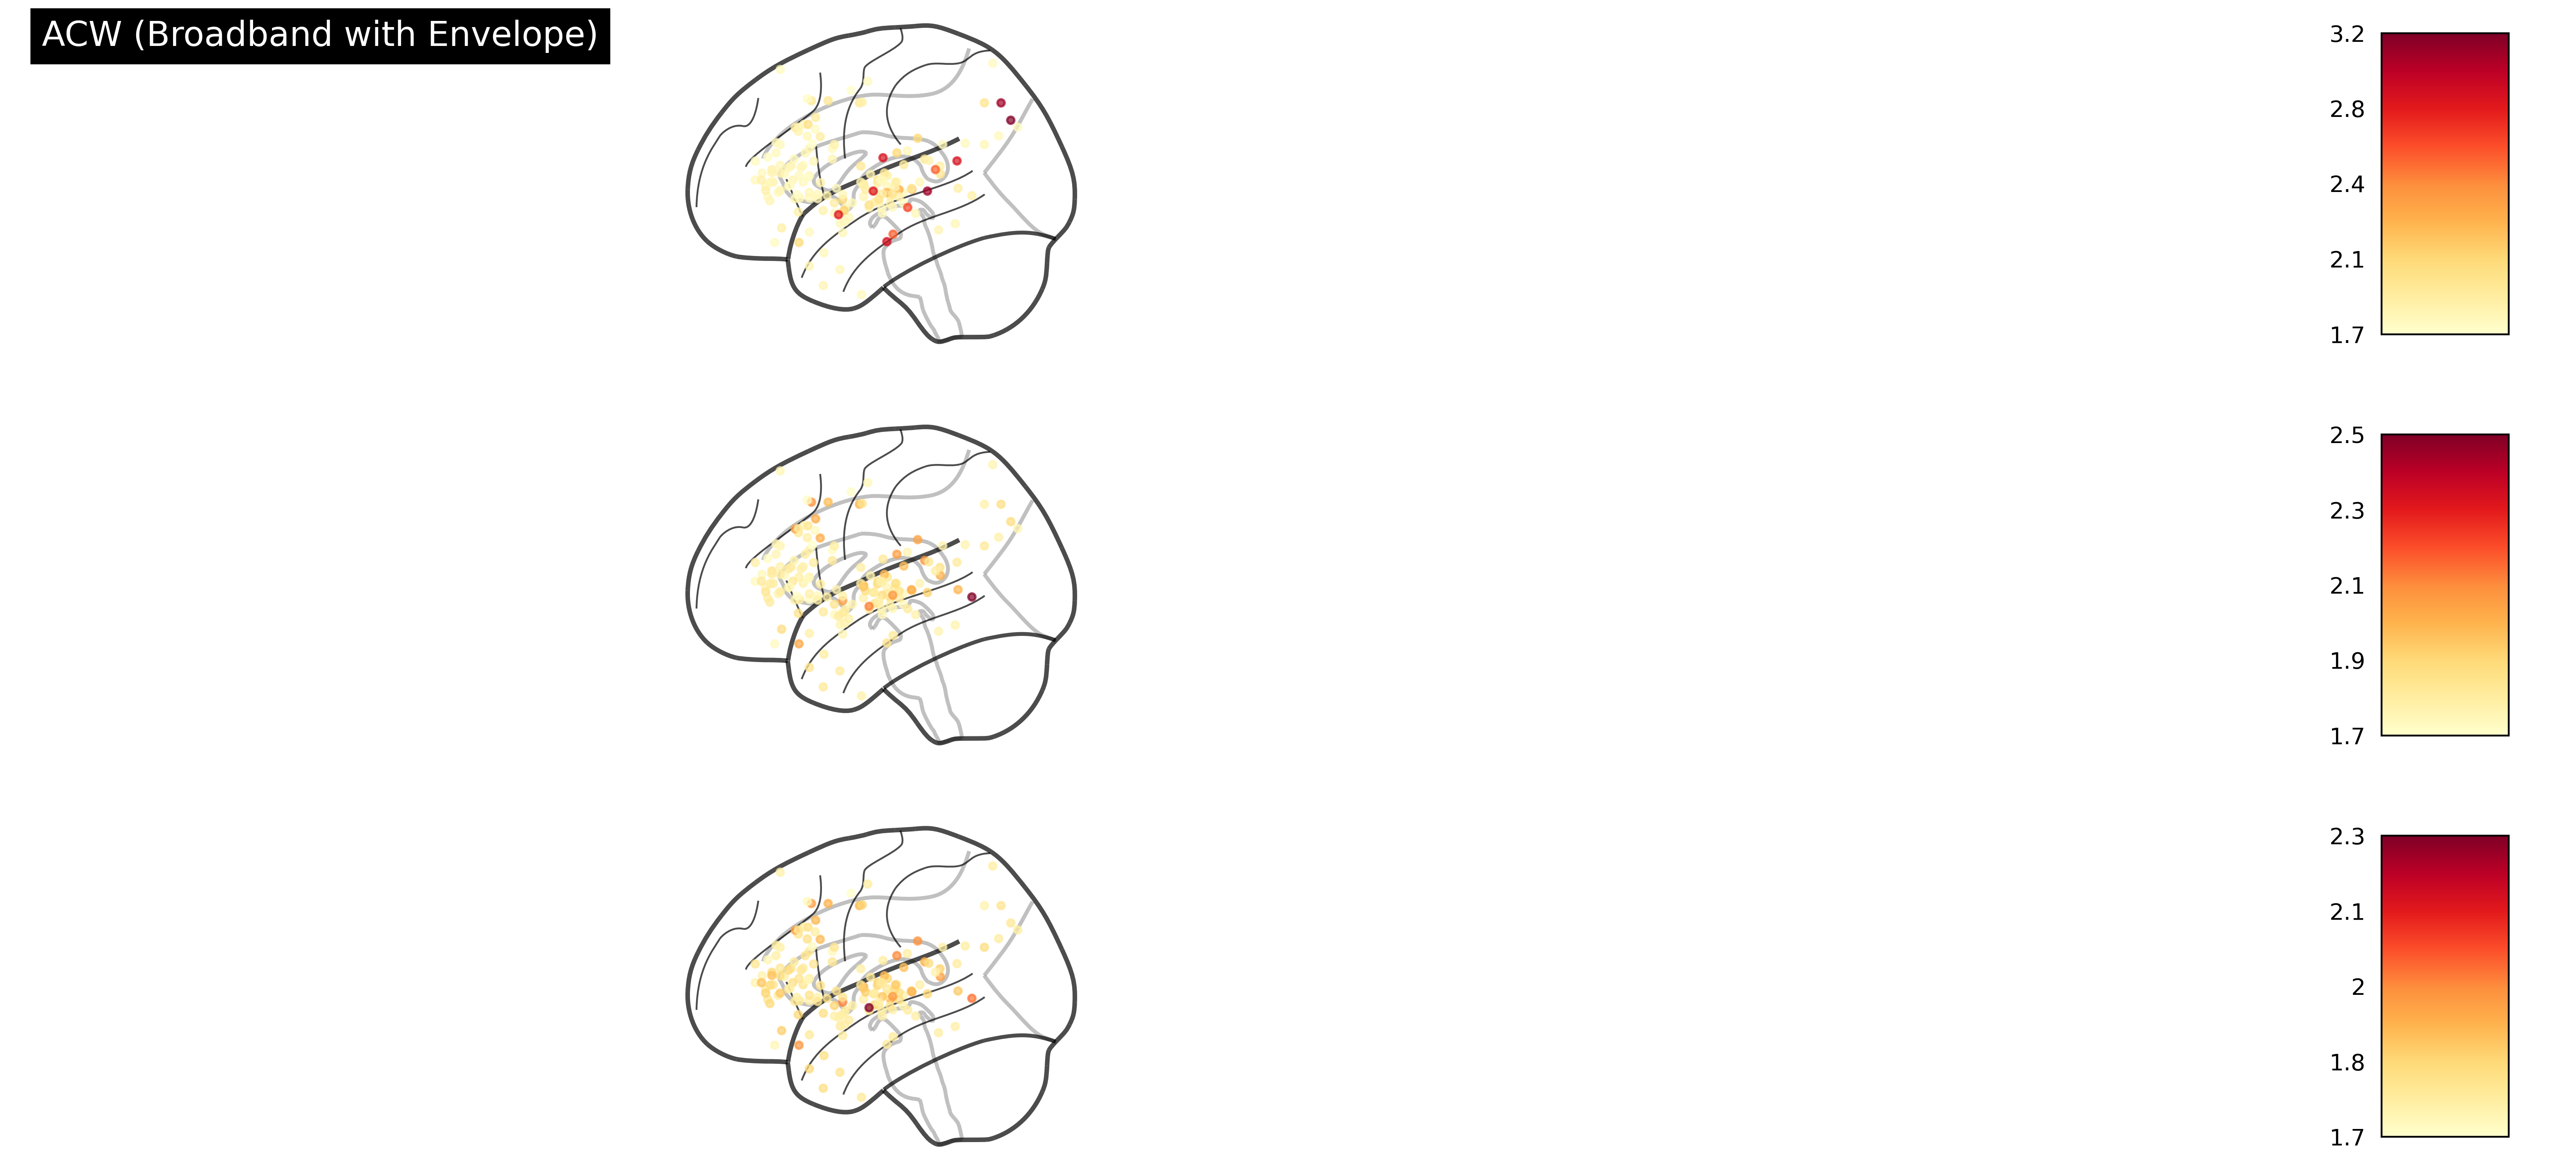

In [301]:
fig, ax = plt.subplots(3, 1, figsize=(20, 9), dpi=400)
plotting.plot_markers(
    node_values=np.log(first_ACW_avgs), 
    node_coords = node_coordinates,
    node_cmap=cm.YlOrRd,
    node_size=10,
    # node_vmax=79,
    title = 'ACW (Broadband with Envelope)',
    colorbar=True,
    display_mode='l',
    axes=ax[0]
)
plotting.plot_markers(
    node_values=np.log(second_ACW_avgs), 
    node_coords = node_coordinates,
    node_cmap=cm.YlOrRd,
    node_size=10,
    # node_vmax=70,
    display_mode='l',
    axes=ax[1]
)
plotting.plot_markers(
    node_values=np.log(third_ACW_avgs), 
    node_coords = node_coordinates,
    node_cmap=cm.YlOrRd,
    node_size=10,
    # node_vmax=70,
    display_mode='l',
    axes=ax[2]
)
# ax.text(0.5, 0.1, 'First Chunk', ha='center', va='center', transform=ax.transAxes, fontsize=12)
# ax[1].text(0.5, 0.1, 'Middle Chunk', ha='center', va='center', transform=ax[1].transAxes, fontsize=12)
# ax[2].text(0.5, 0.1, 'Last Chunk', ha='center', va='center', transform=ax[2].transAxes, fontsize=12)
plt.savefig('broadband-chunks_envelope_filter_acw.svg')
plt.show()

In [102]:
elect_audio_corrs = pd.read_csv('audio-electrode-correlations.csv')
elect_audio_corrs.head()

,Unnamed: 0,0
0,0,0.044307
1,1,0.008148
2,2,0.010961
3,3,0.049751
4,4,0.000127


# Correlation to TRW Plot

In [324]:
elect_audio_corrs = elect_audio_corrs.loc[:, ~elect_audio_corrs.columns.str.contains('^Unnamed')]
elect_audio_corrs

,0
0,0.044307
1,0.008148
2,0.010961
3,0.049751
4,0.000127
...,...
155,0.037184
156,0.041660
157,-0.003078
158,-0.008888


In [348]:
df_sorted['audio_corr'] = elect_audio_corrs
df_sorted

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec,ACW_first_chunk,ACW_second_chunk,ACW_third_chunk,audio_corr
0,662,EEGPO_02REF,-62.0,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2,6.288875,12.004671,7.562125,0.044307
1,717,LGA47,-74.0,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47,5.672782,5.597101,5.667232,0.008148
2,717,LGB119,-72.0,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119,5.871968,5.921137,5.878103,0.010961
3,717,LGB126,-74.0,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126,5.775789,5.675998,5.716767,0.049751
4,717,LGB71,-58.0,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71,5.772184,5.711588,5.733839,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...
155,798,G92,-61.0,39.000000,-2.000000,parstriangularis,NY798_111_Part1_conversation1_G92,92,5.959483,6.007316,6.210301,0.037184
156,798,G93,-62.0,34.000000,3.000000,parstriangularis,NY798_111_Part1_conversation1_G93,93,5.942385,5.961015,6.458407,0.041660
157,798,G94,-64.0,29.333333,5.333333,parstriangularis,NY798_111_Part1_conversation1_G94,94,5.623036,5.598540,5.748983,-0.003078
158,798,G96,-66.0,24.000000,14.000000,parsopercularis,NY798_111_Part1_conversation1_G96,96,5.908835,5.839409,5.904507,-0.008888


In [364]:
origin = np.array([-73.333333, -15.000000, 1.333333])

dists = []
for i, row in df_sorted.iterrows():
    # electrode_loc = np.array([row.x, row.y, row.z])
    dist = np.sqrt((row.x - origin[0])**2 + (row.y - origin[1])**2 + (row.z - origin[2])**2)
    dists.append(dist)

df_sorted['distance_to_origin'] = dists

In [371]:
df_sorted.region.value_counts()

region
parstriangularis              26
mSTG                          25
parsopercularis               19
mMTG                           9
cSTG                           9
rostralmiddlefrontal           8
precentral                     8
rMTG                           6
postcentral                    6
Unknown                        5
r                              5
inferiorparietal               5
Left-Cerebral-White-Matter     4
rSTG                           4
supramarginal                  4
caudalmiddlefrontal            3
cMTG                           2
superiortemporal_div1          2
superiortemporal_div2          2
inferiortemporal               1
parsorbitalis                  1
lateralorbitofrontal           1
isthmuscingulate               1
middletemporal_div2            1
superiorfrontal                1
bankssts                       1
fusiform                       1
Name: count, dtype: int64

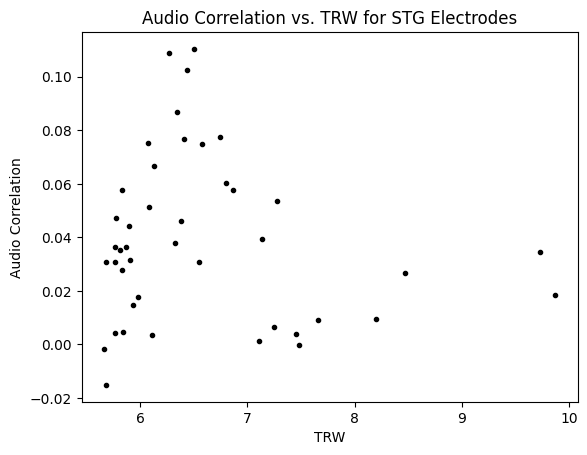

In [452]:
df_stg = df_sorted[df_sorted.region.isin(['cSTG', 'mSTG', 'rSTG'])]
df_stg = df_sorted[df_sorted.region.isin(['cSTG', 'mSTG', 'rSTG', 'superiortemporal_div1', 'superiortemporal_div2', 'bankssts'])]

x = (df_stg['ACW_first_chunk'] + df_stg['ACW_second_chunk'] + df_stg['ACW_third_chunk']) / 3
y = df_stg['audio_corr']
c = df_stg['distance_to_origin'].to_numpy()
c = 'k'

plt.scatter(x, y, c=c, marker='.', label='First Chunk (0-10 min)')
plt.ylabel('Audio Correlation')
plt.xlabel('TRW')
plt.title('Audio Correlation vs. TRW for STG Electrodes')
# plt.colorbar()
# plt.legend()
plt.savefig('audio-correlations-TRW.svg')
plt.show()

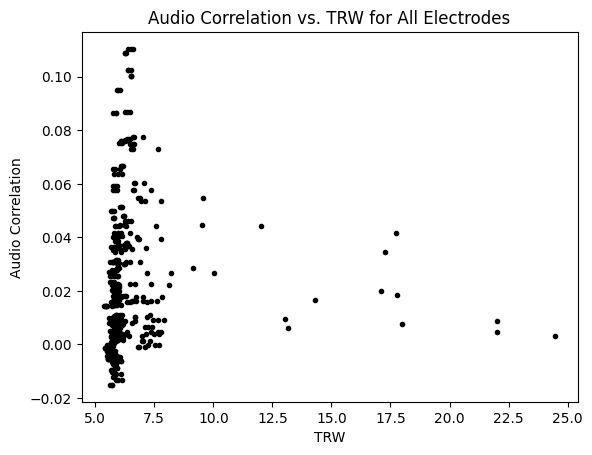

In [321]:
plt.scatter(first_ACW_avgs,elect_audio_corrs, c='k', marker='.',
            label='First Chunk (0-10 min)')
plt.scatter(second_ACW_avgs,elect_audio_corrs, c='k',
           label='Second Chunk (10-20 min)', marker='.')
plt.scatter(third_ACW_avgs,elect_audio_corrs, c='k',
           label='Third Chunk (20-30 min)',marker='.')
plt.ylabel('Audio Correlation')
plt.xlabel('TRW')
plt.title('Audio Correlation vs. TRW for All Electrodes')
# plt.legend()
# plt.savefig('audio-correlations-TRW.svg')
plt.show()

## Plot of Top Six Brain Regions and their Average ACWs per Chunk

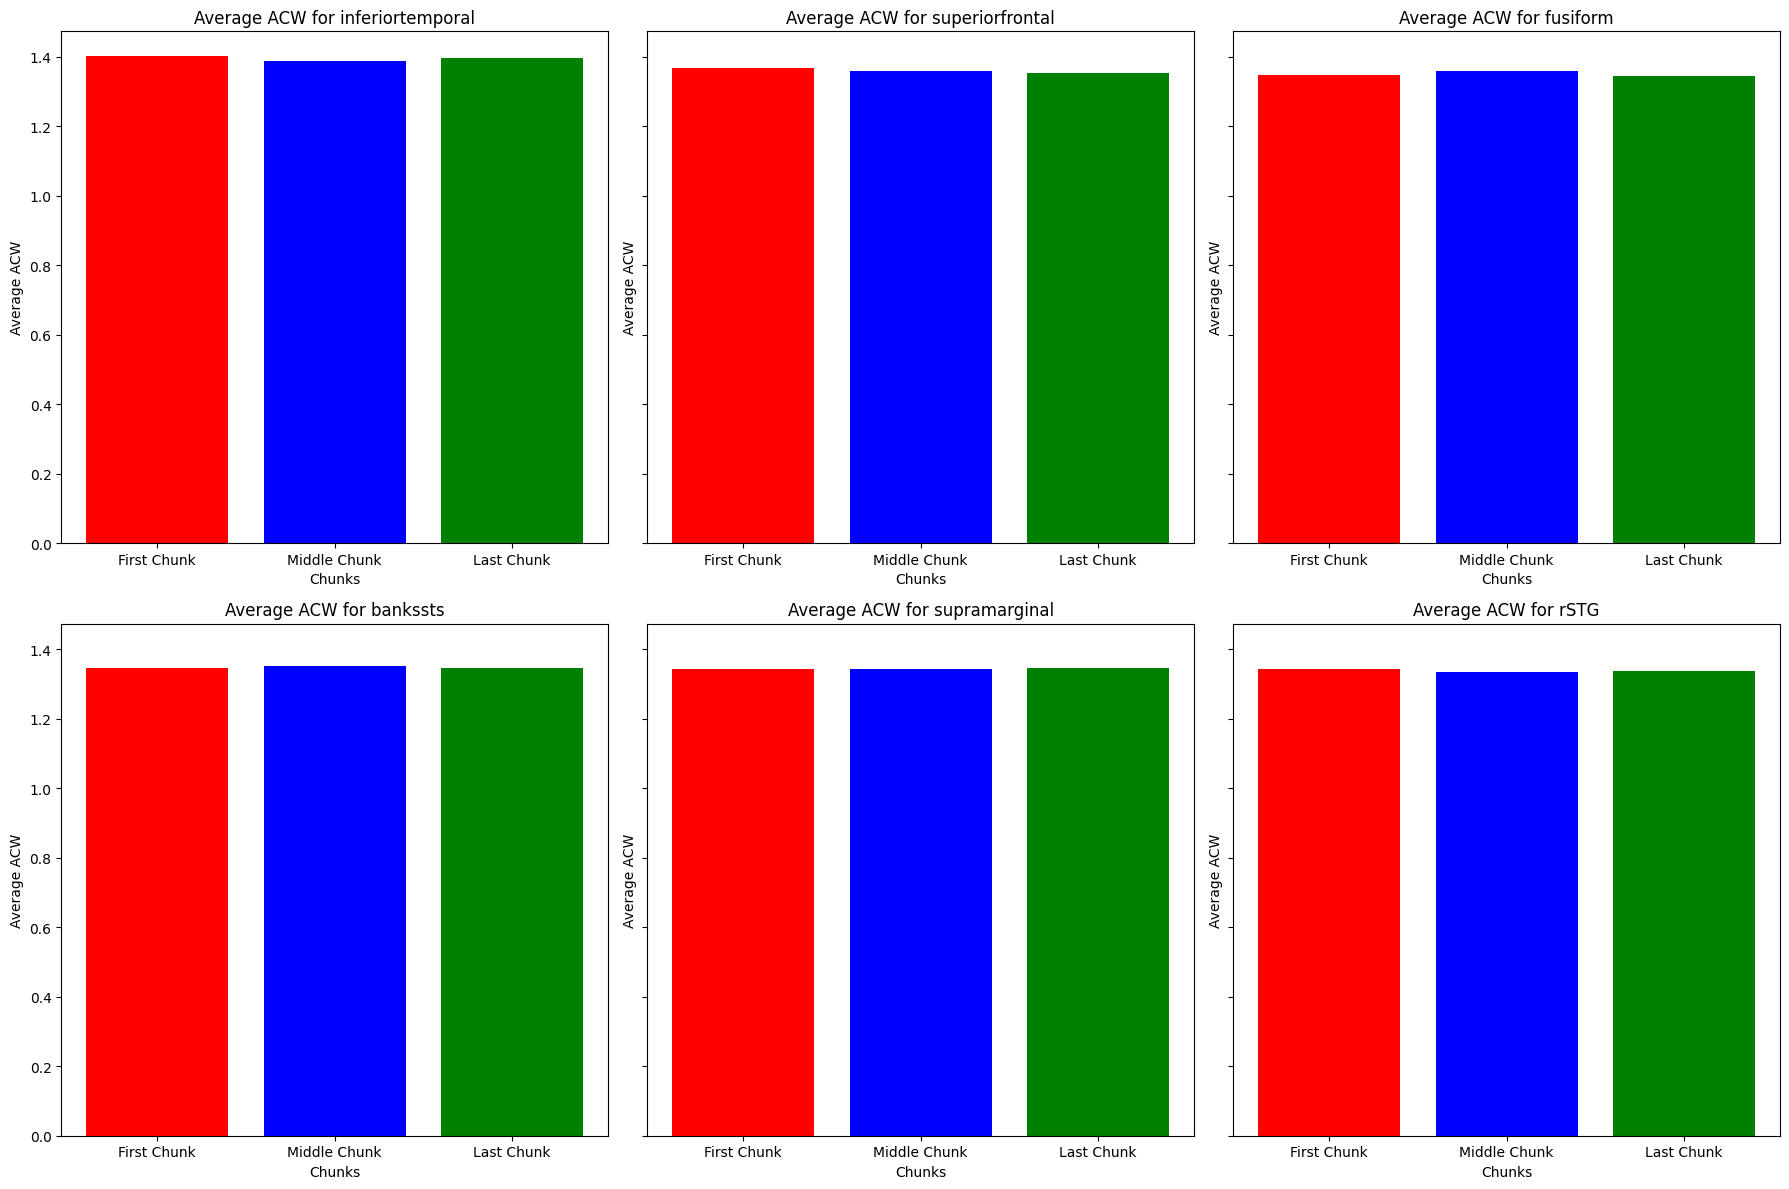

In [278]:
# Calculate the combined average ACW for each region
df_sorted['ACW_combined'] = df_sorted[['ACW_first_chunk', 'ACW_second_chunk', 'ACW_third_chunk']].mean(axis=1)

# Group by region and calculate the mean ACW for each chunk
grouped_df = df_sorted.groupby('region').agg({
    'ACW_first_chunk': 'mean',
    'ACW_second_chunk': 'mean',
    'ACW_third_chunk': 'mean',
    'ACW_combined': 'mean'
}).reset_index()
# Plotting
num_regions = grouped_df.shape[0]

# Select the top 6 regions based on the combined average ACW
top_6_regions = grouped_df.nlargest(6, 'ACW_combined')
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for i, region in enumerate(top_6_regions['region']):
    region_data = top_6_regions[top_6_regions['region'] == region]
    acw_values = [region_data['ACW_first_chunk'].values[0],
                  region_data['ACW_second_chunk'].values[0],
                  region_data['ACW_third_chunk'].values[0]]
    axes[i].bar(['First Chunk', 'Middle Chunk', 'Last Chunk'], acw_values, color=['red', 'blue', 'green'])
    axes[i].set_title(f'Average ACW for {region}')
    axes[i].set_xlabel('Chunks')
    axes[i].set_ylabel('Average ACW')

plt.tight_layout()
plt.savefig('avg_acw_regions.svg')
plt.show()

In [537]:
df_sorted['region'].sort_values().unique()

array(['Left-Cerebral-White-Matter', 'Unknown', 'bankssts', 'cMTG',
       'cSTG', 'caudalmiddlefrontal', 'fusiform', 'inferiorparietal',
       'inferiortemporal', 'isthmuscingulate', 'lateralorbitofrontal',
       'mMTG', 'mSTG', 'middletemporal_div2', 'parsopercularis',
       'parsorbitalis', 'parstriangularis', 'postcentral', 'precentral',
       'r', 'rMTG', 'rSTG', 'rostralmiddlefrontal', 'superiorfrontal',
       'superiortemporal_div1', 'superiortemporal_div2', 'supramarginal'],
      dtype=object)

In [254]:
num_regions

27

# Plot Electrodes by Region

In [160]:
grouped_df = df_sorted.groupby('region')
grouped_df.head()

,subject_number,electrode_name,x,y,z,region,subject_electrode,elec
0,662,EEGPO_02REF,-62.000000,-58.000000,0.500000,mMTG,NY662_111_Part1_conversation1_EEGPO_02REF,2
1,717,LGA47,-74.000000,-25.000000,-3.000000,mMTG,NY717_111_Part1_conversation1_LGA47,47
2,717,LGB119,-72.000000,-8.666667,-5.333333,mMTG,NY717_111_Part1_conversation1_LGB119,119
3,717,LGB126,-74.000000,-20.000000,-5.000000,mMTG,NY717_111_Part1_conversation1_LGB126,126
4,717,LGB71,-58.000000,36.000000,21.000000,rostralmiddlefrontal,NY717_111_Part1_conversation1_LGB71,71
...,...,...,...,...,...,...,...,...
137,798,O6,-58.000000,-64.000000,25.000000,cMTG,NY798_111_Part1_conversation1_O6,142
138,798,AIT3,-42.000000,-5.000000,-47.000000,fusiform,NY798_111_Part1_conversation1_AIT3,131
139,798,O4,-45.333333,-80.000000,33.333333,inferiorparietal,NY798_111_Part1_conversation1_O4,140
140,798,DPI3,-50.000000,-15.000000,8.000000,Left-Cerebral-White-Matter,NY798_111_Part1_conversation1_DPI3,191


In [445]:
# Define the ROIs for plotting electrodes by region
rois = [
    (['mSTG', 'cSTG', 'rSTG'],'Superior Temporal Gyrus'),
    (['parsopercularis', 'parstriangularis', 'parsorbitalis'],'Inferior Frontal Gyrus'),
    (['supramarginal', 'inferiorparietal'],'Parietal Lobe'),
    (['cMTG', 'mMTG', 'rMTG'],'Middle Temporal Gyrus'),
    (['caudalmiddlefrontal', 'rostralmiddlefrontal'],'Middle Frontal Gyrus')
]

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_56154/2844346210.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


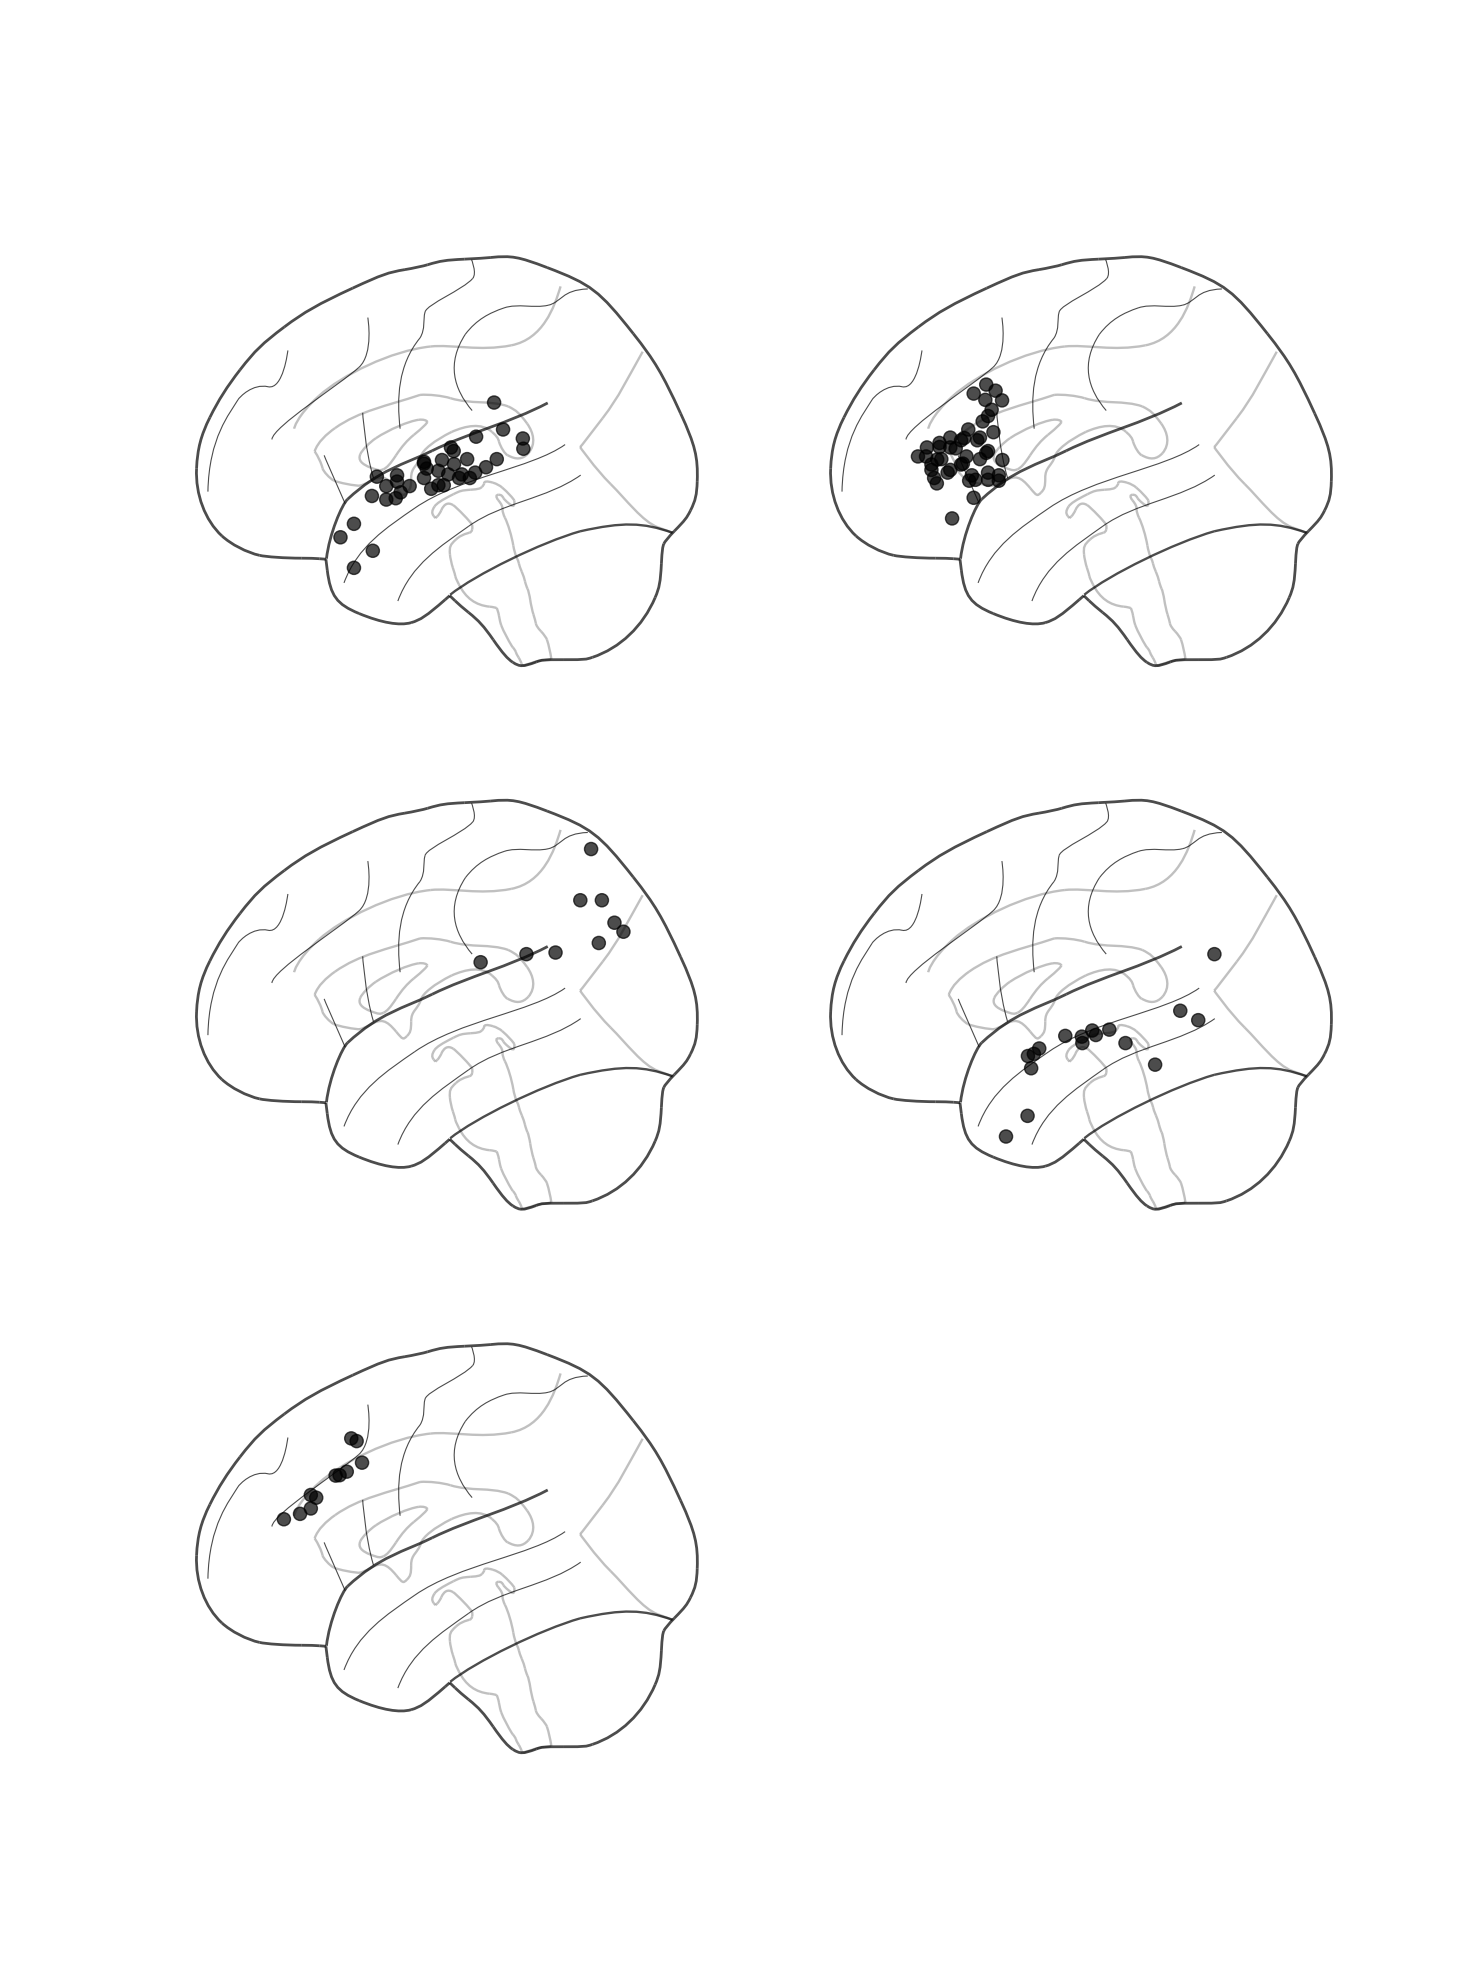

In [453]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for idx, (region_list, roi_name) in enumerate(rois):
    ax = axes[idx]
    
    # Extract coordinates for the regions in the current ROI
    roi_coords = []
    for region in region_list:
        if region in grouped_df.groups:
            group = grouped_df.get_group(region)
            coords = group[['x', 'y', 'z']].values.tolist()
            roi_coords.extend(coords)
    
    # Convert to numpy array for plotting
    roi_coords = np.array(roi_coords)
    
    # Plot using nilearn's plot_markers
    
    node_values = np.ones(len(roi_coords))
    plotting.plot_markers(
        node_values=node_values,
        node_coords=roi_coords,
        figure=fig,
        axes=ax,
        node_cmap='Grays',
        node_size=90,
        node_vmin=0.9,
        node_vmax=0.9,
        display_mode='l',
        # title=roi_name,
        colorbar=False  
        )
    # ax.set_title(roi_name)

# Adjust layout and remove any unused subplots
plt.tight_layout()
for ax in axes[len(rois):]:
    fig.delaxes(ax)

plt.savefig('bigger-electrode-region-locations.svg')
plt.show()

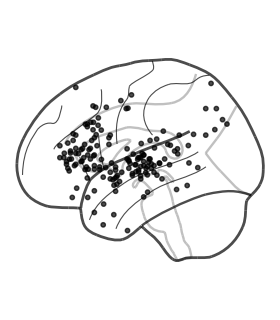

In [614]:
plotting.plot_markers(
    node_values=first_ACW_avgs, 
    node_coords = node_coordinates,
    node_cmap='Grays',
    node_size=10,
    node_vmin=0.9,
    node_vmax=0.9,
    # title = 'ACW (Theta Power 4-8Hz)',
    colorbar=False,
    display_mode='l'
)
plt.savefig('electrode-placement.svg')
plt.show()

In [279]:
# !ls -l /Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw